In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'

In [2]:
df = pd.read_csv("data/mam17_test_data.csv") # 50% duty-cycle

df['Pi'] = df['Ii'] * df['Vi']
df['Po'] = df['Io'] * df['Vo']
df['Eff'] = df['Po'] / df['Pi']
df['Eff'] = df['Eff'].fillna(value=0)

print('Mean Eff:', df[1:]['Eff'].mean())

df

Mean Eff: 0.86599880950182


,Ii,Io,Vi,Vo,Pi,Po,Eff
0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000
1,5.4,7.8,35.4,22.2,191.16,173.16,0.905838
2,17.1,29.9,33.0,16.5,564.30,493.35,0.874269
3,26.1,45.2,32.1,15.9,837.81,718.68,0.857808
4,32.9,59.2,31.1,15.2,1023.19,899.84,0.879446
5,41.4,74.6,30.3,14.5,1254.42,1081.70,0.862311
6,47.9,87.9,25.5,11.7,1221.45,1028.43,0.841975
7,55.0,106.4,22.1,9.6,1215.50,1021.44,0.840346


In [3]:
df['Io'] * (df['Vo'] / df['Vi']) / df['Eff']

0     NaN
1     5.4
2    17.1
3    26.1
4    32.9
5    41.4
6    47.9
7    55.0
dtype: float64

0.86599880950182


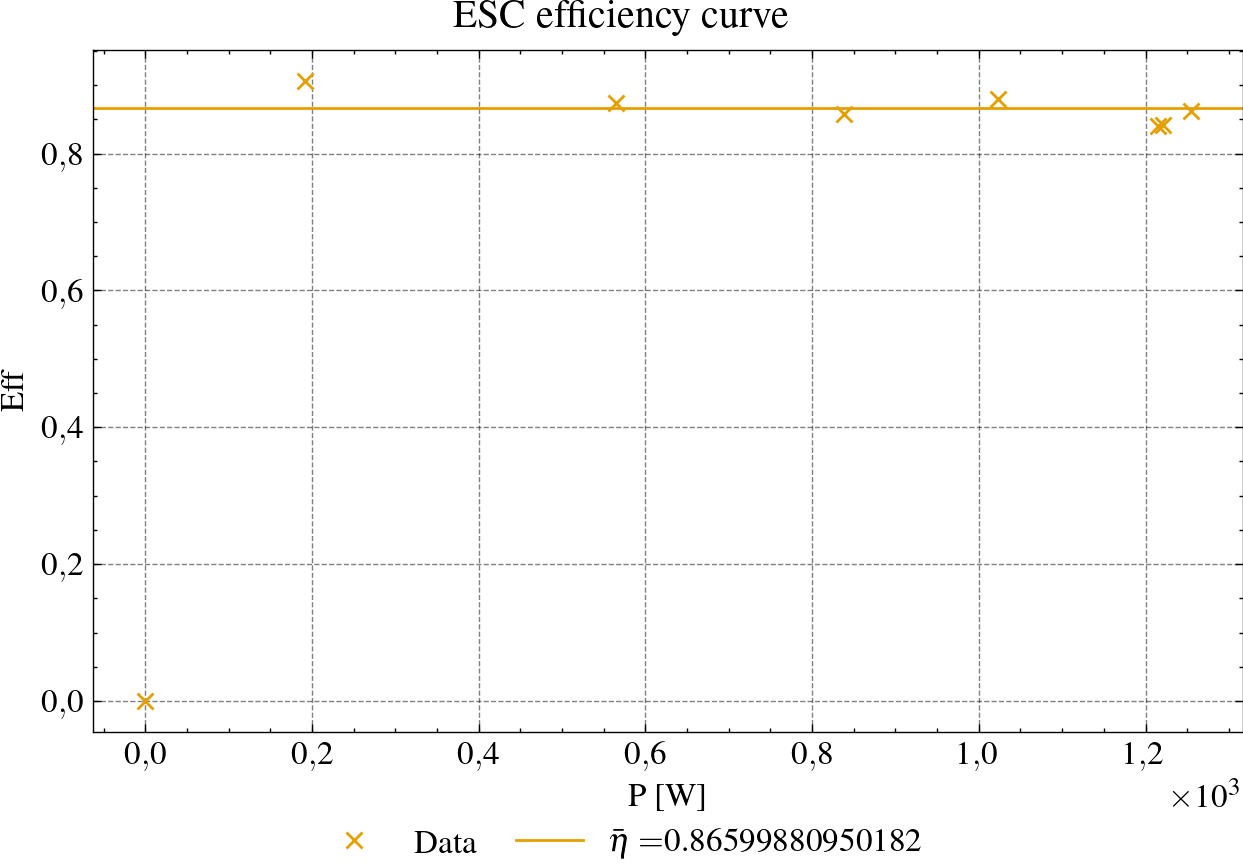

In [4]:
eff_mean = df['Eff'].to_numpy()[1:].mean()
print(eff_mean)

# Plot the original data and the fitted curve
plt.figure()
plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.axhline(eff_mean, label=r'$\bar{\eta} = $' + str(eff_mean))
plt.xlabel('P [W]')
plt.ylabel('Eff')

fig_save_and_show(None, None, 'ESC efficiency curve', ncol=2)

### Motor RMS from AVG current:

In [5]:
import sympy as sp
import numpy as np

# ============================
# Symbols
# ============================

t, u = sp.symbols('t u', real=True)
R, L, Vin, E = sp.symbols('R L Vin E', positive=True, real=True)
Ts, esc_d = sp.symbols('Ts D', positive=True, real=True)

Ton  = esc_d*Ts
Toff = Ts - Ton

I0, I1 = sp.symbols('I0 I1', real=True)

# ============================
# 1. ON interval: di/dt = (Vin - E - R*i)/L
# ============================

i = sp.Function('i')
ode_on = sp.Eq(sp.diff(i(t), t), (Vin - E - R*i(t))/L)
sol_on = sp.dsolve(ode_on, ics={i(0): I0})
i_on = sp.simplify(sol_on.rhs)
I1_expr = sp.simplify(i_on.subs(t, Ton))

# ============================
# 2. OFF interval: di/dt = (-E - R*i)/L, with u = t - Ton
# ============================

i2 = sp.Function('i2')
ode_off = sp.Eq(sp.diff(i2(u), u), (-E - R*i2(u))/L)
sol_off = sp.dsolve(ode_off, ics={i2(0): I1})
i_off_local = sp.simplify(sol_off.rhs)
i_off = i_off_local.subs(u, t - Ton)

# ============================
# 3. Periodicity: i(Ts) = I0
# ============================

periodic_eq = sp.Eq(i_off.subs(t, Ts), I0)
periodic_eq_sub = sp.simplify(periodic_eq.subs(I1, I1_expr))
I0_solution = sp.solve(periodic_eq_sub, I0)[0]

# Steady-state waveforms
i_on_ss  = sp.simplify(i_on.subs(I0, I0_solution))
I1_ss    = sp.simplify(I1_expr.subs(I0, I0_solution))
i_off_ss = sp.simplify(i_off.subs({I0: I0_solution, I1: I1_ss}))

# ============================
# 4. Mean current
# ============================

mean_expr = (
    sp.integrate(i_on_ss,  (t, 0, Ton)) +
    sp.integrate(i_off_ss, (t, Ton, Ts))
) / Ts
mean_expr_simpl = sp.simplify(mean_expr)

# Extract the generic branch of Piecewise
if isinstance(mean_expr_simpl, sp.Piecewise):
    mean_br = mean_expr_simpl.args[0][0]
else:
    mean_br = mean_expr_simpl

# This simplifies exactly to (D*Vin - E)/R
mean_closed = sp.simplify(mean_br)

# ============================
# 5. RMS^2 current
# ============================

rms_sq_expr = (
    sp.integrate(i_on_ss**2,  (t, 0, Ton)) +
    sp.integrate(i_off_ss**2, (t, Ton, Ts))
) / Ts
rms_sq_simpl = sp.simplify(rms_sq_expr)

if isinstance(rms_sq_simpl, sp.Piecewise):
    rms_sq_br = rms_sq_simpl.args[0][0]
else:
    rms_sq_br = rms_sq_simpl

rms_sq_br = sp.simplify(rms_sq_br)

# ============================
# 6. Variance σ² = Irms² - Imean²
# ============================

var_expr = sp.simplify(rms_sq_br - mean_closed**2)

print("sigma^2 free symbols:", var_expr.free_symbols)
# -> {D, R, L, Ts, Vin}  (E is gone)

# Optional: define Phi = var_expr * R^2 / Vin^2
Phi = sp.simplify(var_expr * R**2 / Vin**2)
alpha = sp.symbols('alpha', positive=True, real=True)
Phi_alpha = sp.simplify(Phi.subs(Ts, alpha*L/R))

print("\nI_mean (closed form) =", mean_closed)
print("\nPhi(D, alpha) =", Phi_alpha)

# New symbol for average current as input to the mapping
Iavg = sp.symbols('Iavg', real=True)

# Exact mapping:
# Irms^2 = Iavg^2 + sigma^2,  where sigma^2 = var_expr (no E)
Irms_sq_from_Iavg_expr = sp.simplify(Iavg**2 + var_expr)
Irms_from_Iavg_expr    = sp.sqrt(Irms_sq_from_Iavg_expr)

print("\nIrms^2(Iavg, D, Vin, R, L, Ts) =")
print(Irms_sq_from_Iavg_expr)


# Lambdified numerical function:
#   Irms_from_Iavg(D, Vin, R, L, Ts, Iavg)
Irms_from_Iavg = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg),
    Irms_from_Iavg_expr,
    'numpy'
)



sigma^2 free symbols: {R, Ts, Vin, L, D}

I_mean (closed form) = (D*Vin - E)/R

Phi(D, alpha) = (D**2*alpha*exp(D*alpha) - D**2*alpha*exp(alpha*(D + 1)) - D*alpha*exp(D*alpha) + D*alpha*exp(alpha*(D + 1)) + exp(alpha) + exp(2*D*alpha) - exp(D*alpha) - exp(alpha*(D + 1)))*exp(-D*alpha)/(alpha*(exp(alpha) - 1))

Irms^2(Iavg, D, Vin, R, L, Ts) =
-(-Iavg**2*R**3*Ts*(exp(R*Ts/L) - 1)*exp(D*R*Ts/L) - Vin**2*(D**2*R*Ts*exp(D*R*Ts/L) - D**2*R*Ts*exp(R*Ts*(D + 1)/L) - D*R*Ts*exp(D*R*Ts/L) + D*R*Ts*exp(R*Ts*(D + 1)/L) + L*exp(R*Ts/L) + L*exp(2*D*R*Ts/L) - L*exp(D*R*Ts/L) - L*exp(R*Ts*(D + 1)/L)))*exp(-D*R*Ts/L)/(R**3*Ts*(exp(R*Ts/L) - 1))


In [6]:
import sympy as sp
import numpy as np

# ============================
# 0. Symbols
# ============================

t, u = sp.symbols('t u', real=True)
R, L, Vin, E = sp.symbols('R L Vin E', positive=True, real=True)
Ts, esc_d = sp.symbols('Ts D', positive=True, real=True)

Ton  = esc_d*Ts
Toff = Ts - Ton

I0, I1 = sp.symbols('I0 I1', real=True)
Iavg   = sp.symbols('Iavg', real=True)   # will be our I_AVG input

# ============================
# 1. ON interval: di/dt = (Vin - E - R*i)/L
# ============================

i = sp.Function('i')
ode_on = sp.Eq(sp.diff(i(t), t), (Vin - E - R*i(t))/L)
sol_on = sp.dsolve(ode_on, ics={i(0): I0})
i_on = sp.simplify(sol_on.rhs)
I1_expr = sp.simplify(i_on.subs(t, Ton))   # i(Ton)

# ============================
# 2. OFF interval: di/dt = (-E - R*i)/L, u = t - Ton
# ============================

i2 = sp.Function('i2')
ode_off = sp.Eq(sp.diff(i2(u), u), (-E - R*i2(u))/L)
sol_off = sp.dsolve(ode_off, ics={i2(0): I1})
i_off_local = sp.simplify(sol_off.rhs)
i_off = i_off_local.subs(u, t - Ton)

# ============================
# 3. Periodicity: i(Ts) = I0  -> solve for I0
# ============================

periodic_eq = sp.Eq(i_off.subs(t, Ts), I0)
periodic_eq_sub = sp.simplify(periodic_eq.subs(I1, I1_expr))
I0_solution = sp.solve(periodic_eq_sub, I0)[0]

# Steady-state waveforms
i_on_ss  = sp.simplify(i_on.subs(I0, I0_solution))
I1_ss    = sp.simplify(I1_expr.subs(I0, I0_solution))
i_off_ss = sp.simplify(i_off.subs({I0: I0_solution, I1: I1_ss}))

# ============================
# 4. TOTAL mean and RMS (for sanity + Irms_from_Iavg)
# ============================

mean_expr = (
    sp.integrate(i_on_ss,  (t, 0, Ton)) +
    sp.integrate(i_off_ss, (t, Ton, Ts))
) / Ts
mean_expr_simpl = sp.simplify(mean_expr)

if isinstance(mean_expr_simpl, sp.Piecewise):
    mean_closed = sp.simplify(mean_expr_simpl.args[0][0])
else:
    mean_closed = sp.simplify(mean_expr_simpl)
# mean_closed = (D*Vin - E)/R

rms_sq_expr = (
    sp.integrate(i_on_ss**2,  (t, 0, Ton)) +
    sp.integrate(i_off_ss**2, (t, Ton, Ts))
) / Ts
rms_sq_simpl = sp.simplify(rms_sq_expr)

if isinstance(rms_sq_simpl, sp.Piecewise):
    rms_sq_br = sp.simplify(rms_sq_simpl.args[0][0])
else:
    rms_sq_br = rms_sq_simpl

# Variance sigma^2 = Irms^2 - Imean^2  (E drops out)
var_expr = sp.simplify(rms_sq_br - mean_closed**2)

# Irms^2 as function of Iavg: Irms^2 = Iavg^2 + sigma^2
Irms_sq_from_Iavg_expr = sp.simplify(Iavg**2 + var_expr)
Irms_from_Iavg_expr    = sp.sqrt(Irms_sq_from_Iavg_expr)

# ============================
# 5. MOSFET RMS^2 over ON interval
# ============================

Imos_sq_expr = (1/Ts) * sp.integrate(i_on_ss**2, (t, 0, Ton))
Imos_sq_simpl = sp.simplify(Imos_sq_expr)

if isinstance(Imos_sq_simpl, sp.Piecewise):
    Imos_sq_br = sp.simplify(Imos_sq_simpl.args[0][0])
else:
    Imos_sq_br = Imos_sq_simpl

# Replace E using Iavg relation: Iavg = (D*Vin - E)/R -> E = D*Vin - R*Iavg
E_sub = esc_d*Vin - R*Iavg
Imos_sq_Iavg = sp.simplify(Imos_sq_br.subs(E, E_sub))
# free symbols: {D, Vin, R, L, Ts, Iavg}
# MOSFET RMS:
Imos_from_Iavg_expr = sp.sqrt(Imos_sq_Iavg)

# ============================
# 6. DIODE RMS^2 over OFF interval
# ============================

Id_sq_expr = (1/Ts) * sp.integrate(i_off_ss**2, (t, Ton, Ts))
Id_sq_simpl = sp.simplify(Id_sq_expr)

if isinstance(Id_sq_simpl, sp.Piecewise):
    Id_sq_br = sp.simplify(Id_sq_simpl.args[0][0])
else:
    Id_sq_br = Id_sq_simpl

Id_sq_Iavg = sp.simplify(Id_sq_br.subs(E, E_sub))
Id_from_Iavg_expr = sp.sqrt(Id_sq_Iavg)

# ============================
# 7. Device parameters & conduction loss expressions
# ============================

esc_Rds_on = sp.symbols('Rds_on', positive=True, real=True)   # MOSFET Rds_on @ 100°C
esc_V_F, esc_r_D = sp.symbols('V_F r_D', positive=True, real=True)  # diode VF, r_D @ 100°C
esc_Fs = sp.symbols('fs', positive=True, real=True)
esc_E_on, esc_E_off, esc_Qrr = sp.symbols('Eon Eoff Qrr', positive=True, real=True)

# MOSFET conduction loss: P = I_MOS,RMS^2 * Rds_on
P_mos_cond_expr = sp.simplify(Imos_sq_Iavg * esc_Rds_on)

# Diode average current (from duty + Iavg):
Id_avg_expr_from_Iavg = (1 - esc_d) * Iavg

# Diode conduction loss: P = V_F * I_D,AVG + r_D * I_D,RMS^2
P_d_cond_expr = sp.simplify(esc_V_F * Id_avg_expr_from_Iavg + esc_r_D * Id_sq_Iavg)

# Simple switching-loss models (optional)
P_mos_sw_E_expr = sp.simplify((esc_E_on + esc_E_off) * esc_Fs)      # using Eon/Eoff from datasheet
P_d_sw_expr     = sp.simplify(esc_Qrr * Vin * esc_Fs)         # using Qrr from datasheet

# ============================
# 8. Lambdified numerical functions
# ============================

Irms_from_Iavg = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg),
    Irms_from_Iavg_expr,
    'numpy'
)

Imos_from_Iavg = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg),
    Imos_from_Iavg_expr,
    'numpy'
)

Id_from_Iavg = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg),
    Id_from_Iavg_expr,
    'numpy'
)

P_mos_cond_func = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg, esc_Rds_on),
    P_mos_cond_expr,
    'numpy'
)

P_d_cond_func = sp.lambdify(
    (esc_d, Vin, R, L, Ts, Iavg, esc_V_F, esc_r_D),
    P_d_cond_expr,
    'numpy'
)

P_mos_swE_func = sp.lambdify(
    (esc_E_on, esc_E_off, esc_Fs),
    P_mos_sw_E_expr,
    'numpy'
)

P_d_sw_func = sp.lambdify(
    (esc_Qrr, Vin, esc_Fs),
    P_d_sw_expr,
    'numpy'
)

In [7]:
# Substitute E = D*Vin - R*Iavg into the steady-state waveforms
E_sub = esc_d*Vin - R*Iavg

i_on_Iavg  = sp.simplify(i_on_ss.subs(E, E_sub))
i_off_Iavg = sp.simplify(i_off_ss.subs(E, E_sub))

# Lambdified numeric versions: i(t; D, Vin, R, L, Ts, Iavg)
i_on_num  = sp.lambdify((t, esc_d, Vin, R, L, Ts, Iavg), i_on_Iavg,  'numpy')
i_off_num = sp.lambdify((t, esc_d, Vin, R, L, Ts, Iavg), i_off_Iavg, 'numpy')


In [8]:
import numpy as np

def waveform_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=4000):
    """
    Build steady-state i(t) over one period for given parameters,
    using the exact analytical waveform expressed in terms of Iavg.
    """
    Ton_val = D_val * Ts_val

    n_on  = max(2, int(N * D_val))
    n_off = max(2, int(N * (1.0 - D_val)))

    t_on  = np.linspace(0.0, Ton_val, n_on,  endpoint=False)
    t_off = np.linspace(Ton_val, Ts_val,    n_off, endpoint=True)

    i_on_vals  = i_on_num(t_on,  D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)
    i_off_vals = i_off_num(t_off, D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)

    t_all = np.concatenate([t_on,  t_off])
    i_all = np.concatenate([i_on_vals, i_off_vals])

    return t_all, i_all

def numeric_rms_checks(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=4000):
    """
    Compute numeric RMS (total, MOSFET, diode) by integrating the waveform
    and compare with analytic Irms_from_Iavg, Imos_from_Iavg, Id_from_Iavg.
    """
    # Analytic values
    Irms_a = Irms_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)
    Imos_a = Imos_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)
    Id_a   = Id_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)

    # Numeric waveform
    t_all, i_all = waveform_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=N)
    Ton_val = D_val * Ts_val

    # Masks for MOSFET (ON interval) and diode (OFF interval)
    mos_mask = t_all < Ton_val
    dio_mask = ~mos_mask

    # Total RMS
    Irms_n = np.sqrt(np.trapz(i_all**2, t_all) / Ts_val)

    # MOSFET RMS: (1/Ts) * ∫_0^{DTs} i^2 dt
    Imos_n = np.sqrt(np.trapz(i_all[mos_mask]**2, t_all[mos_mask]) / Ts_val)

    # Diode RMS: (1/Ts) * ∫_{DTs}^{Ts} i^2 dt
    Id_n = np.sqrt(np.trapz(i_all[dio_mask]**2, t_all[dio_mask]) / Ts_val)

    return (Irms_a, Imos_a, Id_a), (Irms_n, Imos_n, Id_n)


In [9]:
# Fixed values
Vin_val = 35.0
fs_val  = 12e3
Ts_val  = 1.0 / fs_val
Iavg_val = 25.0  # choose any average current you care about

D_vals = [0.01, 0.2, 0.5, 0.8, 0.99]
R_vals = [0.05, 0.10]
L_vals = [100e-6, 200e-6, 500e-6]

print("{:>4} {:>6} {:>8} {:>12} {:>12} {:>12}".format(
    "D", "R", "L[µH]", "rel_err_Irms", "rel_err_Imos", "rel_err_Id"
))

for D_val in D_vals:
    for R_val in R_vals:
        for L_val in L_vals:
            (Irms_a, Imos_a, Id_a), (Irms_n, Imos_n, Id_n) = numeric_rms_checks(
                D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=20000
            )

            rel_Irms = (Irms_a - Irms_n) / Irms_n
            rel_Imos = (Imos_a - Imos_n) / Imos_n
            rel_Id   = (Id_a   - Id_n)   / Id_n

            print("{:4.2f} {:6.3f} {:8.1f} {:12.3e} {:12.3e} {:12.3e}".format(
                D_val, R_val, L_val*1e6, rel_Irms, rel_Imos, rel_Id
            ))


   D      R    L[µH] rel_err_Irms rel_err_Imos   rel_err_Id
0.01  0.050    100.0    1.525e-11    2.538e-03    4.745e-10
0.01  0.050    200.0    3.367e-10    2.525e-03   -1.441e-08
0.01  0.050    500.0   -1.730e-09    2.458e-03    1.150e-07
0.01  0.100    100.0   -5.743e-12    2.538e-03    3.124e-11
0.01  0.100    200.0    3.807e-12    2.524e-03    4.694e-11
0.01  0.100    500.0   -8.753e-11    2.516e-03   -1.196e-08
0.20  0.050    100.0   -6.929e-11    1.490e-04    8.960e-12
0.20  0.050    200.0    3.413e-10    1.368e-04    1.677e-08
0.20  0.050    500.0    1.254e-09    1.317e-04   -2.300e-07
0.20  0.100    100.0   -4.832e-11    1.489e-04   -1.649e-11
0.20  0.100    200.0   -1.736e-11    1.368e-04    1.670e-10
0.20  0.100    500.0    1.393e-11    1.297e-04   -7.779e-09
0.50  0.050    100.0   -8.482e-11    6.512e-05    1.608e-09
0.50  0.050    200.0    2.332e-10    5.748e-05   -3.426e-08
0.50  0.050    500.0    1.490e-09    5.229e-05    4.888e-08
0.50  0.100    100.0   -7.370e-11    6.5

In [10]:
# Waveform in terms of Iavg (same E_sub)
i_on_Iavg  = sp.simplify(i_on_ss.subs(E, E_sub))
i_off_Iavg = sp.simplify(i_off_ss.subs(E, E_sub))

i_on_num  = sp.lambdify((t, esc_d, Vin, R, L, Ts, Iavg), i_on_Iavg,  'numpy')
i_off_num = sp.lambdify((t, esc_d, Vin, R, L, Ts, Iavg), i_off_Iavg, 'numpy')

def waveform_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=4000):
    Ton_val = D_val * Ts_val
    n_on  = max(2, int(N * D_val))
    n_off = max(2, int(N * (1.0 - D_val)))

    t_on  = np.linspace(0.0, Ton_val, n_on,  endpoint=False)
    t_off = np.linspace(Ton_val, Ts_val,    n_off, endpoint=True)

    i_on_vals  = i_on_num(t_on,  D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)
    i_off_vals = i_off_num(t_off, D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)

    t_all = np.concatenate([t_on,  t_off])
    i_all = np.concatenate([i_on_vals, i_off_vals])
    return t_all, i_all

# Numeric check at Iavg = 0
Iavg_val = 0
t_vec, i_vec = waveform_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, N=20000)
Irms_num = np.sqrt(np.trapz(i_vec**2, t_vec) / Ts_val)
Irms_analytic = Imos_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)

print("Numeric Imos_rms =", Irms_num)
print("Analytic Imos_rms =", float(Irms_analytic))
print("Relative error =", (Irms_analytic - Irms_num)/Irms_num)


Numeric Imos_rms = 0.01667095392054006
Analytic Imos_rms = 0.017320474631753697
Relative error = 0.038961220474214825


In [11]:
# ============================
# 9. Example of use
# ============================

if __name__ == "__main__":
    # inputs:
    D_val   = 0.5
    Vin_val = 35.0
    Iavg_val = 25.0

    # params:
    R_val   = 0.1
    L_val   = 200e-6
    fs_val  = 12e3
    Ts_val  = 1.0 / fs_val
    Rds_on_val = 2e-3      # example
    V_F_val    = 0.9       # example
    r_D_val    = 1e-3      # example
    Eon_val    = 50e-6     # J
    Eoff_val   = 40e-6     # J
    Qrr_val    = 200e-9    # C

    Irms_tot = Irms_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val)
    Imos_rms = Imos_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val) if D_val != 0 else 0
    Id_rms   = Id_from_Iavg(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val) if D_val != 1 else 0

    # Outputs:
    P_mos_cond = P_mos_cond_func(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, Rds_on_val)
    P_d_cond   = P_d_cond_func(D_val, Vin_val, R_val, L_val, Ts_val, Iavg_val, V_F_val, r_D_val)
    P_mos_sw   = P_mos_swE_func(Eon_val, Eoff_val, fs_val)
    P_d_sw     = P_d_sw_func(Qrr_val, Vin_val, fs_val)
    P_loss     = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw

    print("Irms_total [A] =", float(Irms_tot))
    print("Imos_rms   [A] =", float(Imos_rms))
    print("Id_rms     [A] =", float(Id_rms))
    print("P_mos_cond [W] =", float(P_mos_cond))
    print("P_d_cond   [W] =", float(P_d_cond))
    print("P_mos_sw   [W] =", float(P_mos_sw))
    print("P_d_sw     [W] =", float(P_d_sw))
    print("P_loss     [W] =", float(P_loss))



Irms_total [A] = 25.022142733572416
Imos_rms   [A] = 17.69779777257469
Id_rms     [A] = 17.68885472244155
P_mos_cond [W] = 0.626424091997899
P_d_cond   [W] = 11.562895581391642
P_mos_sw   [W] = 1.08
P_d_sw     [W] = 0.084
P_loss     [W] = 13.35331967338954


## ESC Average Model

In [12]:
def esc_model_avg(batt_v, motor_i, esc_d, esc_params):
    """
    ESC averaged model.

    Inputs
    ------
    batt_v : float
        Battery / DC bus voltage [V]
    motor_i : float
        Average motor current (load current) [A]
    esc_d : float
        Duty cycle (0..1)

    esc_params : dict
        {
          "R_a": ...,
          "L_a": ...,
          "fs": ...,
          "Rds_on": ...,
          "V_F": ...,
          "r_D": ...,
          "Eon": ...,
          "Eoff": ...,
          "Qrr": ...,
          ...
        }

    Outputs
    -------
    motor_v : float
        Average motor voltage [V]
    batt_i  : float
        Average battery current [A]
    P_loss  : float
        Total ESC loss power [W]
    """

    R_a   = esc_params["R_a"]
    L_a   = esc_params["L_a"]
    fs    = esc_params["fs"]
    Ts    = 1.0 / fs

    Rds_on = esc_params["Rds_on"]
    V_F    = esc_params["V_F"]
    r_D    = esc_params["r_D"]
    Eon    = esc_params["Eon"]
    Eoff   = esc_params["Eoff"]
    Qrr    = esc_params["Qrr"]

    D = esc_d
    Vin = batt_v
    Iavg = motor_i

    # motor voltage (keep ideal buck mapping)
    motor_v = D * Vin

    if Iavg <= 0.0:
        # no load current: only switching loss
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        P_mos_sw   = P_mos_swE_func(Eon, Eoff, fs)
        P_d_sw     = P_d_sw_func(Qrr, Vin, fs)
    else:
        # RMS currents from closed-form SymPy-derived functions
        # Imos_rms = Imos_from_Iavg(D, Vin, R_a, L_a, Ts, Iavg)
        # Id_rms   = Id_from_Iavg(D, Vin, R_a, L_a, Ts, Iavg)

        # Conduction losses
        P_mos_cond = P_mos_cond_func(D, Vin, R_a, L_a, Ts, Iavg, Rds_on)
        P_d_cond   = P_d_cond_func(D, Vin, R_a, L_a, Ts, Iavg, V_F, r_D)

        # Switching losses
        P_mos_sw = P_mos_swE_func(Eon, Eoff, fs)
        P_d_sw   = P_d_sw_func(Qrr, Vin, fs)

    P_loss = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw

    # Input current from power balance
    batt_i = (motor_v * motor_i + P_loss) / batt_v if batt_v > 0 else 0.0

    return motor_v, batt_i, P_loss

def esc_model_avg2(batt_v, motor_i, esc_d, esc_params):
    """
    ESC averaged model with:
      - conduction losses as effective voltage drop
      - switching losses as extra battery current

    Inputs
    ------
    batt_v  : float  (V_b)
    motor_i : float  (I_m, average motor/load current)
    esc_d   : float  (D, duty cycle)

    esc_params : dict
      R_a, L_a, fs, Rds_on, V_F, r_D, Eon, Eoff, Qrr, ...
    """
    Vb  = batt_v
    Im  = motor_i
    D   = esc_d

    R_a   = esc_params["R_a"]
    L_a   = esc_params["L_a"]
    fs    = esc_params["fs"]
    Ts    = 1.0 / fs

    Rds_on = esc_params["Rds_on"]
    V_F    = esc_params["V_F"]
    r_D    = esc_params["r_D"]
    Eon    = esc_params["Eon"]
    Eoff   = esc_params["Eoff"]
    Qrr    = esc_params["Qrr"]

    Vin = Vb
    Iavg = Im

    # Edge cases: no duty or no current
    if D <= 0.0 or Im <= 0.0 or Vb <= 0.0:
        motor_v = D * Vb
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        P_mos_sw   = P_mos_swE_func(Eon, Eoff, fs)
        P_d_sw     = P_d_sw_func(Qrr, Vin, fs)
        P_cond     = 0.0
        P_sw       = P_mos_sw + P_d_sw
        batt_i     = (motor_v * Im + P_sw) / Vb if Vb > 0 else 0.0
        P_loss     = P_sw
        return motor_v, batt_i, P_loss

    # === 1) RMS currents and conduction losses ===
    # Imos_rms = Imos_from_Iavg(D, Vin, R_a, L_a, Ts, Iavg)
    # Id_rms   = Id_from_Iavg(D, Vin, R_a, L_a, Ts, Iavg)

    P_mos_cond = P_mos_cond_func(D, Vin, R_a, L_a, Ts, Iavg, Rds_on)
    P_d_cond   = P_d_cond_func(D, Vin, R_a, L_a, Ts, Iavg, V_F, r_D)
    P_cond     = P_mos_cond + P_d_cond

    # === 2) Switching losses ===
    P_mos_sw = P_mos_swE_func(Eon, Eoff, fs)
    P_d_sw   = P_d_sw_func(Qrr, Vin, fs)
    P_sw     = P_mos_sw + P_d_sw

    # === 3) Outputs ===
    # Conduction: effective voltage drop
    motor_v = D * Vb - P_cond / Im

    # Switching: extra battery current
    batt_i  = D * Im + P_sw / Vb

    P_loss = P_cond + P_sw

    return motor_v, batt_i, P_loss




In [13]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# 1. SymPy setup to derive RMS and loss functions

t, u = sp.symbols('t u', real=True)
R, L, Vin, E = sp.symbols('R L Vin E', positive=True, real=True)
Ts, esc_d = sp.symbols('Ts D', positive=True, real=True)

Ton = esc_d * Ts
Toff = Ts - Ton

I0, I1 = sp.symbols('I0 I1', real=True)
Iavg = sp.symbols('Iavg', real=True)

# ON interval ODE: di/dt = (Vin - E - R*i)/L
i = sp.Function('i')
ode_on = sp.Eq(sp.diff(i(t), t), (Vin - E - R * i(t)) / L)
sol_on = sp.dsolve(ode_on, ics={i(0): I0})
i_on = sp.simplify(sol_on.rhs)
I1_expr = sp.simplify(i_on.subs(t, Ton))

# OFF interval ODE: di/dt = (-E - R*i)/L, with u = t - Ton
i2 = sp.Function('i2')
ode_off = sp.Eq(sp.diff(i2(u), u), (-E - R * i2(u)) / L)
sol_off = sp.dsolve(ode_off, ics={i2(0): I1})
i_off_local = sp.simplify(sol_off.rhs)
i_off = i_off_local.subs(u, t - Ton)

# Periodicity: i(Ts) = I0
periodic_eq = sp.Eq(i_off.subs(t, Ts), I0)
periodic_eq_sub = sp.simplify(periodic_eq.subs(I1, I1_expr))
I0_solution = sp.solve(periodic_eq_sub, I0)[0]

# Steady-state waveforms
i_on_ss = sp.simplify(i_on.subs(I0, I0_solution))
I1_ss = sp.simplify(I1_expr.subs(I0, I0_solution))
i_off_ss = sp.simplify(i_off.subs({I0: I0_solution, I1: I1_ss}))

# Mean current
mean_expr = (sp.integrate(i_on_ss, (t, 0, Ton)) +
             sp.integrate(i_off_ss, (t, Ton, Ts))) / Ts
mean_expr_simpl = sp.simplify(mean_expr)
if isinstance(mean_expr_simpl, sp.Piecewise):
    mean_closed = sp.simplify(mean_expr_simpl.args[0][0])
else:
    mean_closed = sp.simplify(mean_expr_simpl)

# RMS^2 current
rms_sq_expr = (sp.integrate(i_on_ss**2, (t, 0, Ton)) +
               sp.integrate(i_off_ss**2, (t, Ton, Ts))) / Ts
rms_sq_simpl = sp.simplify(rms_sq_expr)
if isinstance(rms_sq_simpl, sp.Piecewise):
    rms_sq_br = sp.simplify(rms_sq_simpl.args[0][0])
else:
    rms_sq_br = rms_sq_simpl

# Variance and Irms_from_Iavg
var_expr = sp.simplify(rms_sq_br - mean_closed**2)
Irms_sq_from_Iavg_expr = sp.simplify(Iavg**2 + var_expr)
Irms_from_Iavg_expr = sp.sqrt(Irms_sq_from_Iavg_expr)

# MOSFET RMS^2 over ON interval
Imos_sq_expr = (1 / Ts) * sp.integrate(i_on_ss**2, (t, 0, Ton))
Imos_sq_simpl = sp.simplify(Imos_sq_expr)
if isinstance(Imos_sq_simpl, sp.Piecewise):
    Imos_sq_br = sp.simplify(Imos_sq_simpl.args[0][0])
else:
    Imos_sq_br = Imos_sq_simpl

# Substitute E using Iavg relation: Iavg = (D*Vin - E)/R -> E = D*Vin - R*Iavg
E_sub = esc_d * Vin - R * Iavg
Imos_sq_Iavg = sp.simplify(Imos_sq_br.subs(E, E_sub))
Imos_from_Iavg_expr = sp.sqrt(Imos_sq_Iavg)

# Diode RMS^2 over OFF interval
Id_sq_expr = (1 / Ts) * sp.integrate(i_off_ss**2, (t, Ton, Ts))
Id_sq_simpl = sp.simplify(Id_sq_expr)
if isinstance(Id_sq_simpl, sp.Piecewise):
    Id_sq_br = sp.simplify(Id_sq_simpl.args[0][0])
else:
    Id_sq_br = Id_sq_simpl
Id_sq_Iavg = sp.simplify(Id_sq_br.subs(E, E_sub))
Id_from_Iavg_expr = sp.sqrt(Id_sq_Iavg)

# Diode average current
Id_avg_expr_from_Iavg = (1 - esc_d) * Iavg

# Device params
esc_Rds_on = sp.symbols('Rds_on', positive=True, real=True)
esc_V_F, esc_r_D = sp.symbols('V_F r_D', positive=True, real=True)
esc_Fs = sp.symbols('fs', positive=True, real=True)
esc_E_on, esc_E_off, esc_Qrr = sp.symbols('Eon Eoff Qrr', positive=True, real=True)

# Conduction loss expressions (symbolic, no overshoot here)
P_mos_cond_expr = sp.simplify(Imos_sq_Iavg * esc_Rds_on)
P_d_cond_expr   = sp.simplify(esc_V_F * Id_avg_expr_from_Iavg + esc_r_D * Id_sq_Iavg)

# Switching loss expressions at Vin (nominal)
P_mos_sw_E_expr = sp.simplify((esc_E_on + esc_E_off) * esc_Fs)
P_d_sw_expr     = sp.simplify(esc_Qrr * Vin * esc_Fs)

# Lambdify numerical functions
Irms_from_Iavg = sp.lambdify((esc_d, Vin, R, L, Ts, Iavg), Irms_from_Iavg_expr, 'numpy')
Imos_from_Iavg = sp.lambdify((esc_d, Vin, R, L, Ts, Iavg), Imos_from_Iavg_expr, 'numpy')
Id_from_Iavg   = sp.lambdify((esc_d, Vin, R, L, Ts, Iavg), Id_from_Iavg_expr, 'numpy')

P_mos_cond_func = sp.lambdify((esc_d, Vin, R, L, Ts, Iavg, esc_Rds_on), P_mos_cond_expr, 'numpy')
P_d_cond_func   = sp.lambdify((esc_d, Vin, R, L, Ts, Iavg, esc_V_F, esc_r_D), P_d_cond_expr, 'numpy')
P_mos_swE_func  = sp.lambdify((esc_E_on, esc_E_off, esc_Fs), P_mos_sw_E_expr, 'numpy')
P_d_sw_func     = sp.lambdify((esc_Qrr, Vin, esc_Fs), P_d_sw_expr, 'numpy')


# ----------------------------------------------------------------------
# Helper: compute effective switching voltage with overshoot
# ----------------------------------------------------------------------
def _sw_voltage_with_overshoot(Vin_val, esc_params):
    """
    Compute effective switching-node voltage used in loss models,
    including overshoot factor esc_params.get('V_ov_pct', 0.0).
    """
    V_ov_pct = esc_params.get("V_ov_pct", 0.0)
    return Vin_val * (1.0 + V_ov_pct)


# ----------------------------------------------------------------------
# 2. ESC models using these functions + overshoot in switching losses
# ----------------------------------------------------------------------

def esc_model_avg(batt_v, motor_i, esc_d, esc_params):
    """
    Model 1: all losses go into input current, motor voltage = D * Vbatt
    """
    Vb = float(batt_v)
    Im = float(motor_i)
    Dv = float(esc_d)

    R_a   = esc_params["R_a"]
    L_a   = esc_params["L_a"]
    fs_val = esc_params["fs"]
    Ts_val = 1.0 / fs_val

    Rds      = esc_params["Rds_on"]
    V_F_val  = esc_params["V_F"]
    r_D_val  = esc_params["r_D"]
    Eon_val  = esc_params["Eon"]
    Eoff_val = esc_params["Eoff"]
    Qrr_val  = esc_params["Qrr"]

    Vin_val  = Vb
    Iavg_val = Im
    Vsw_val  = _sw_voltage_with_overshoot(Vin_val, esc_params)

    motor_v = Dv * Vin_val

    if Iavg_val <= 0.0 or Vb <= 0.0 or Dv <= 0.0:
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        # Scale MOSFET switching energy linearly with Vsw/Vin
        if Vin_val > 0.0:
            P_mos_sw = float(P_mos_swE_func(Eon_val, Eoff_val, fs_val)) * (Vsw_val / Vin_val)
        else:
            P_mos_sw = 0.0
        # Diode Qrr loss uses Vsw directly
        P_d_sw   = float(P_d_sw_func(Qrr_val, Vsw_val, fs_val))
        P_loss   = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw
        batt_i   = (motor_v * Im + P_loss) / Vb if Vb > 0 else 0.0
        return motor_v, batt_i, P_loss

    P_mos_cond = float(P_mos_cond_func(Dv, Vin_val, R_a, L_a, Ts_val, Iavg_val, Rds))
    P_d_cond   = float(P_d_cond_func(Dv, Vin_val, R_a, L_a, Ts_val, Iavg_val, V_F_val, r_D_val))

    if Vin_val > 0.0:
        P_mos_sw = float(P_mos_swE_func(Eon_val, Eoff_val, fs_val)) * (Vsw_val / Vin_val)
    else:
        P_mos_sw = 0.0
    P_d_sw   = float(P_d_sw_func(Qrr_val, Vsw_val, fs_val))

    P_loss = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw
    batt_i = (motor_v * Im + P_loss) / Vb if Vb > 0 else 0.0
    return motor_v, batt_i, P_loss


def esc_model_avg2(batt_v, motor_i, esc_d, esc_params):
    """
    Model 2: conduction losses as voltage drop, switching losses as extra current.
    """
    Vb = float(batt_v)
    Im = float(motor_i)
    Dv = float(esc_d)

    R_a   = esc_params["R_a"]
    L_a   = esc_params["L_a"]
    fs_val = esc_params["fs"]
    Ts_val = 1.0 / fs_val

    Rds      = esc_params["Rds_on"]
    V_F_val  = esc_params["V_F"]
    r_D_val  = esc_params["r_D"]
    Eon_val  = esc_params["Eon"]
    Eoff_val = esc_params["Eoff"]
    Qrr_val  = esc_params["Qrr"]

    Vin_val  = Vb
    Iavg_val = Im
    Vsw_val  = _sw_voltage_with_overshoot(Vin_val, esc_params)

    if Dv <= 0.0 or Im <= 0.0 or Vb <= 0.0:
        motor_v = Dv * Vb
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        if Vin_val > 0.0:
            P_mos_sw = float(P_mos_swE_func(Eon_val, Eoff_val, fs_val)) * (Vsw_val / Vin_val)
        else:
            P_mos_sw = 0.0
        P_d_sw = float(P_d_sw_func(Qrr_val, Vsw_val, fs_val))
        P_cond = 0.0
        P_sw   = P_mos_sw + P_d_sw
        P_loss = P_sw
        batt_i = (motor_v * Im + P_sw) / Vb if Vb > 0 else 0.0
        return motor_v, batt_i, P_loss

    P_mos_cond = float(P_mos_cond_func(Dv, Vin_val, R_a, L_a, Ts_val, Iavg_val, Rds))
    P_d_cond   = float(P_d_cond_func(Dv, Vin_val, R_a, L_a, Ts_val, Iavg_val, V_F_val, r_D_val))
    P_cond     = P_mos_cond + P_d_cond

    if Vin_val > 0.0:
        P_mos_sw = float(P_mos_swE_func(Eon_val, Eoff_val, fs_val)) * (Vsw_val / Vin_val)
    else:
        P_mos_sw = 0.0
    P_d_sw = float(P_d_sw_func(Qrr_val, Vsw_val, fs_val))
    P_sw   = P_mos_sw + P_d_sw

    motor_v = Dv * Vb - P_cond / Im
    batt_i  = Dv * Im + P_sw / Vb
    P_loss  = P_cond + P_sw

    return motor_v, batt_i, P_loss


def esc_model_avg3(batt_v, motor_i, esc_d, esc_params):
    """
    Model 3:
      - Keep ideal current relation: batt_i = D * motor_i
      - All losses (conduction + switching) mapped into motor voltage:
            motor_v = D * batt_v - P_loss / motor_i
    """
    Vb  = float(batt_v)
    Im  = float(motor_i)
    D   = float(esc_d)

    R_a   = esc_params["R_a"]
    L_a   = esc_params["L_a"]
    fs    = esc_params["fs"]
    Ts    = 1.0 / fs

    Rds_on = esc_params["Rds_on"]
    V_F    = esc_params["V_F"]
    r_D    = esc_params["r_D"]
    Eon    = esc_params["Eon"]
    Eoff   = esc_params["Eoff"]
    Qrr    = esc_params["Qrr"]

    Vin  = Vb
    Iavg = Im
    Vsw  = _sw_voltage_with_overshoot(Vin, esc_params)

    if (Vb <= 0.0) or (D <= 0.0) or (Im <= 0.0):
        motor_v = D * Vb
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        if Vin > 0.0:
            P_mos_sw = float(P_mos_swE_func(Eon, Eoff, fs)) * (Vsw / Vin)
        else:
            P_mos_sw = 0.0
        P_d_sw   = float(P_d_sw_func(Qrr, Vsw, fs))
        P_loss   = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw
        batt_i   = D * Im
        return motor_v, batt_i, P_loss

    P_mos_cond = float(P_mos_cond_func(D, Vin, R_a, L_a, Ts, Iavg, Rds_on))
    P_d_cond   = float(P_d_cond_func(D, Vin, R_a, L_a, Ts, Iavg, V_F, r_D))
    P_cond     = P_mos_cond + P_d_cond

    if Vin > 0.0:
        P_mos_sw = float(P_mos_swE_func(Eon, Eoff, fs)) * (Vsw / Vin)
    else:
        P_mos_sw = 0.0
    P_d_sw = float(P_d_sw_func(Qrr, Vsw, fs))
    P_sw   = P_mos_sw + P_d_sw

    P_loss = P_cond + P_sw
    batt_i = D * Im
    motor_v = D * Vb - P_loss / Im

    return motor_v, batt_i, P_loss


def esc_model_avg_4(batt_v, motor_i, esc_d, esc_params):
    """
    Model 4: all losses into input current, motor voltage = D * Vbatt.
    Uses simplified RMS approximation: no ripple, only duty weighting.
    """
    Vb = float(batt_v)
    Im = float(motor_i)
    D  = float(esc_d)

    Rds_on = esc_params["Rds_on"]
    V_F    = esc_params["V_F"]
    r_D    = esc_params["r_D"]
    fs     = esc_params["fs"]
    Eon    = esc_params["Eon"]
    Eoff   = esc_params["Eoff"]
    Qrr    = esc_params["Qrr"]

    Vin = Vb
    Iavg = Im
    Vsw  = _sw_voltage_with_overshoot(Vin, esc_params)

    motor_v = D * Vin

    if Iavg <= 0 or Vb <= 0 or D <= 0:
        P_mos_cond = 0.0
        P_d_cond   = 0.0
        if Vin > 0.0:
            P_mos_sw = (Eon + Eoff) * fs * (Vsw / Vin)
        else:
            P_mos_sw = 0.0
        P_d_sw   = Qrr * Vsw * fs
        P_loss   = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw
        batt_i   = (motor_v * Im + P_loss) / Vb if Vb > 0 else 0.0
        return motor_v, batt_i, P_loss

    Imos_rms = np.sqrt(D) * Iavg
    Id_rms   = np.sqrt(1 - D) * Iavg
    Id_avg   = (1 - D) * Iavg

    P_mos_cond = Imos_rms**2 * Rds_on
    P_d_cond   = V_F * Id_avg + r_D * Id_rms**2

    if Vin > 0.0:
        P_mos_sw = (Eon + Eoff) * fs * (Vsw / Vin)
    else:
        P_mos_sw = 0.0
    P_d_sw = Qrr * Vsw * fs

    P_loss = P_mos_cond + P_d_cond + P_mos_sw + P_d_sw
    batt_i = (motor_v * Im + P_loss) / Vb

    return motor_v, batt_i, P_loss


In [14]:
esc_operation_params = {
    "fs": 12550,                    # Hz  switching frequency
    "V_ov_pct": 2                   # Switching voltage overshoot
}
esc_mosfet_params = {
    # ============================================================
    # MOSFET: IXFN420N10T (Littelfuse / IXYS)
    # ============================================================

    # Rds_on @ 100°C
    #   Rds(on) = 2.3 mΩ max at 25°C  (datasheet page 1)
    #   Normalized Rds(on)(100°C) ≈ 1.6  (datasheet Fig. 4, page 3)
    # → Rds_on(100°C) ≈ 2.3e-3 * 1.6 = 3.68e-3
    "Rds_on": 3.7e-3,                 # ohm

    # Switching times (datasheet page 2)
    #   tr = 155 ns, tf = 255 ns
    # Your model uses Eon/Eoff instead, so we compute:
    #   E ≈ 0.5 * V * I * t
    # For 35 V, 25 A (your operating region):
    #   Eon  ≈ 0.5 * 35 * 25 * 155e-9 = 67.8 µJ
    #   Eoff ≈ 0.5 * 35 * 25 * 255e-9 = 111.6 µJ
    # Rounded conservatively:
    "Eon":  70e-6,                    # J
    "Eoff": 110e-6,                   # J
    "V_F": 1.2,         # V    body diode forward drop at 60 A
    "r_D": 7.5e-3,      # ohm  body diode slope
    "Qrr": 0.38e-6,     # C    body diode reverse recovery charge
    "trr": 140e-9,      # s    body diode reverse recovery time
}
esc_diode_params = {
    # ============================================================
    # DIODE: DSEI2x101-12A (two diodes in parallel)
    # ============================================================

    # Forward conduction:
    #   Vf = 1.87 V at 100 A (page 2)
    #   rF = 6.1 mΩ (page 2)
    # Two diodes in parallel → half slope resistance
    "V_F": 1.87,                      # V  forward drop
    "r_D": 3.05e-3,                   # ohm = 6.1 mΩ / 2

    # Reverse recovery:
    #   Qrr = 0.38 µC per diode (page 2)
    # Two diodes in parallel → half total Qrr
    "Qrr": 0.19e-6,                   # C
}
motor_params = {
    'R_a': 0.01953449524955559,      # ohm
    'L_a': 6.329544121644985e-05,    # H
}
esc_params = esc_operation_params | esc_mosfet_params | esc_diode_params | motor_params


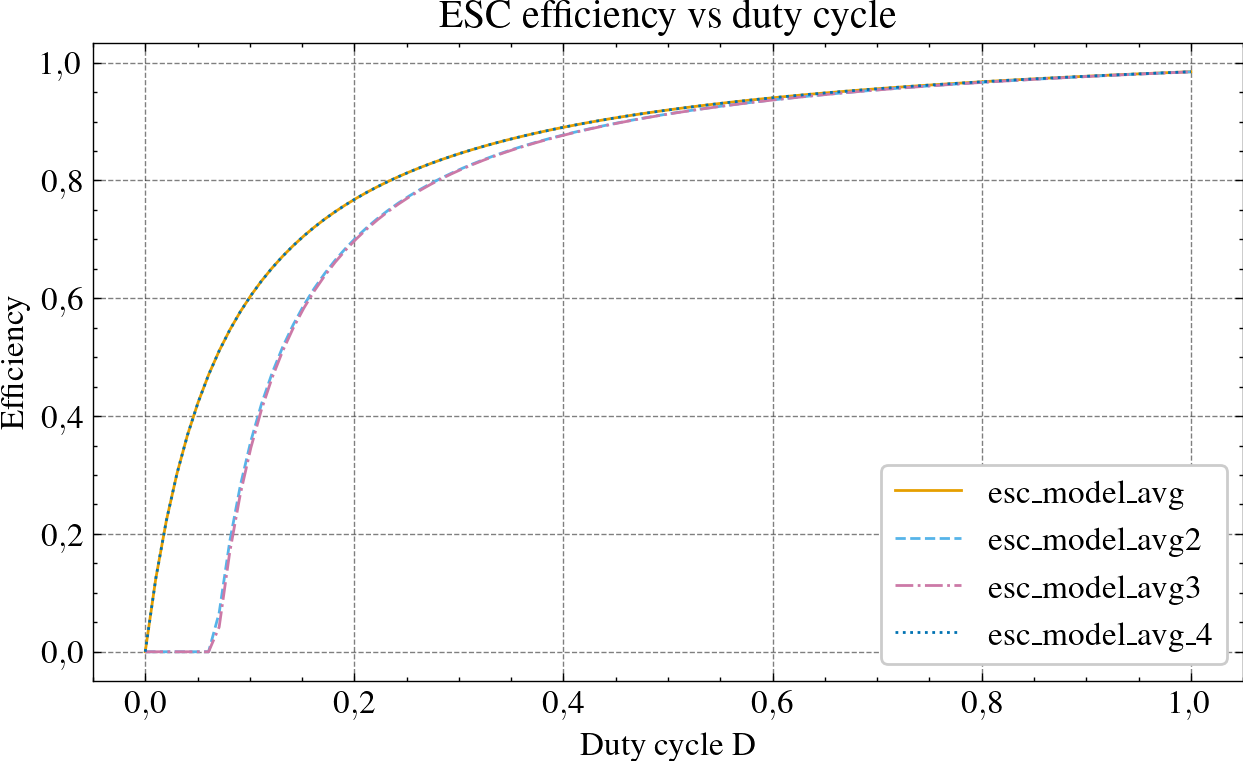

In [15]:
# 3. Sweep duty cycle and compute efficiencies

batt_v = 32.0
motor_i = 120.0

D_vals = np.linspace(0, 1, 100)
eta_4 = []
eta_1 = []
eta_2 = []
eta_3 = []

for D_val in D_vals:
    m_v1, b_i1, P_loss1 = esc_model_avg(batt_v, motor_i, D_val, esc_params)
    Pin1 = batt_v * b_i1
    Pout1 = m_v1 * motor_i
    eta_1.append(Pout1 / Pin1 if Pin1 > 0 else 0)

    m_v2, b_i2, P_loss2 = esc_model_avg2(batt_v, motor_i, D_val, esc_params)
    Pin2 = batt_v * b_i2
    Pout2 = m_v2 * motor_i
    eta_2.append(Pout2 / Pin2 if Pin2 > 0 else 0)

    m_v3, b_i3, P_loss3 = esc_model_avg3(batt_v, motor_i, D_val, esc_params)
    Pin3 = batt_v * b_i3
    Pout3 = m_v3 * motor_i
    eta_3.append(Pout3 / Pin3 if Pin3 > 0 else 0)

    m_v_4, b_i_4, P_loss_4 = esc_model_avg_4(batt_v, motor_i, D_val, esc_params)
    Pin_4 = batt_v * b_i_4
    Pout_4 = m_v_4 * motor_i
    eta_4.append(Pout_4 / Pin_4 if Pin_4 > 0 else 0)

eta_4 = np.clip(np.array(eta_4), 0, 1)
eta_1 = np.clip(np.array(eta_1), 0, 1)
eta_2 = np.clip(np.array(eta_2), 0, 1)
eta_3 = np.clip(np.array(eta_3), 0, 1)

# 4. Plot efficiency vs duty cycle

plt.figure()
plt.plot(D_vals, eta_1, label="esc_model_avg")
plt.plot(D_vals, eta_2, label="esc_model_avg2")
plt.plot(D_vals, eta_3, label="esc_model_avg3")
plt.plot(D_vals, eta_4, label="esc_model_avg_4")
plt.xlabel("Duty cycle D")
plt.ylabel("Efficiency")
plt.title("ESC efficiency vs duty cycle")
plt.legend()
plt.grid(True)
plt.show()


     Ii     Io    Vi    Vo  eta_meas  eta_m1  eta_m2  eta_m3  eta_m4
0   0.0    0.0   0.0   0.0       NaN     NaN     NaN     NaN     NaN
1   5.4    7.8  35.4  22.2    0.9058  0.9046  0.8996  0.8945  0.9048
2  17.1   29.9  33.0  16.5    0.8743  0.9285  0.9240  0.9229  0.9285
3  26.1   45.2  32.1  15.9    0.8578  0.9281  0.9233  0.9225  0.9281
4  32.9   59.2  31.1  15.2    0.8794  0.9254  0.9200  0.9194  0.9254
5  41.4   74.6  30.3  14.5    0.8623  0.9220  0.9160  0.9155  0.9221
6  47.9   87.9  25.5  11.7    0.8420  0.9068  0.8978  0.8972  0.9068
7  55.0  106.4  22.1   9.6    0.8403  0.8905  0.8777  0.8770  0.8905


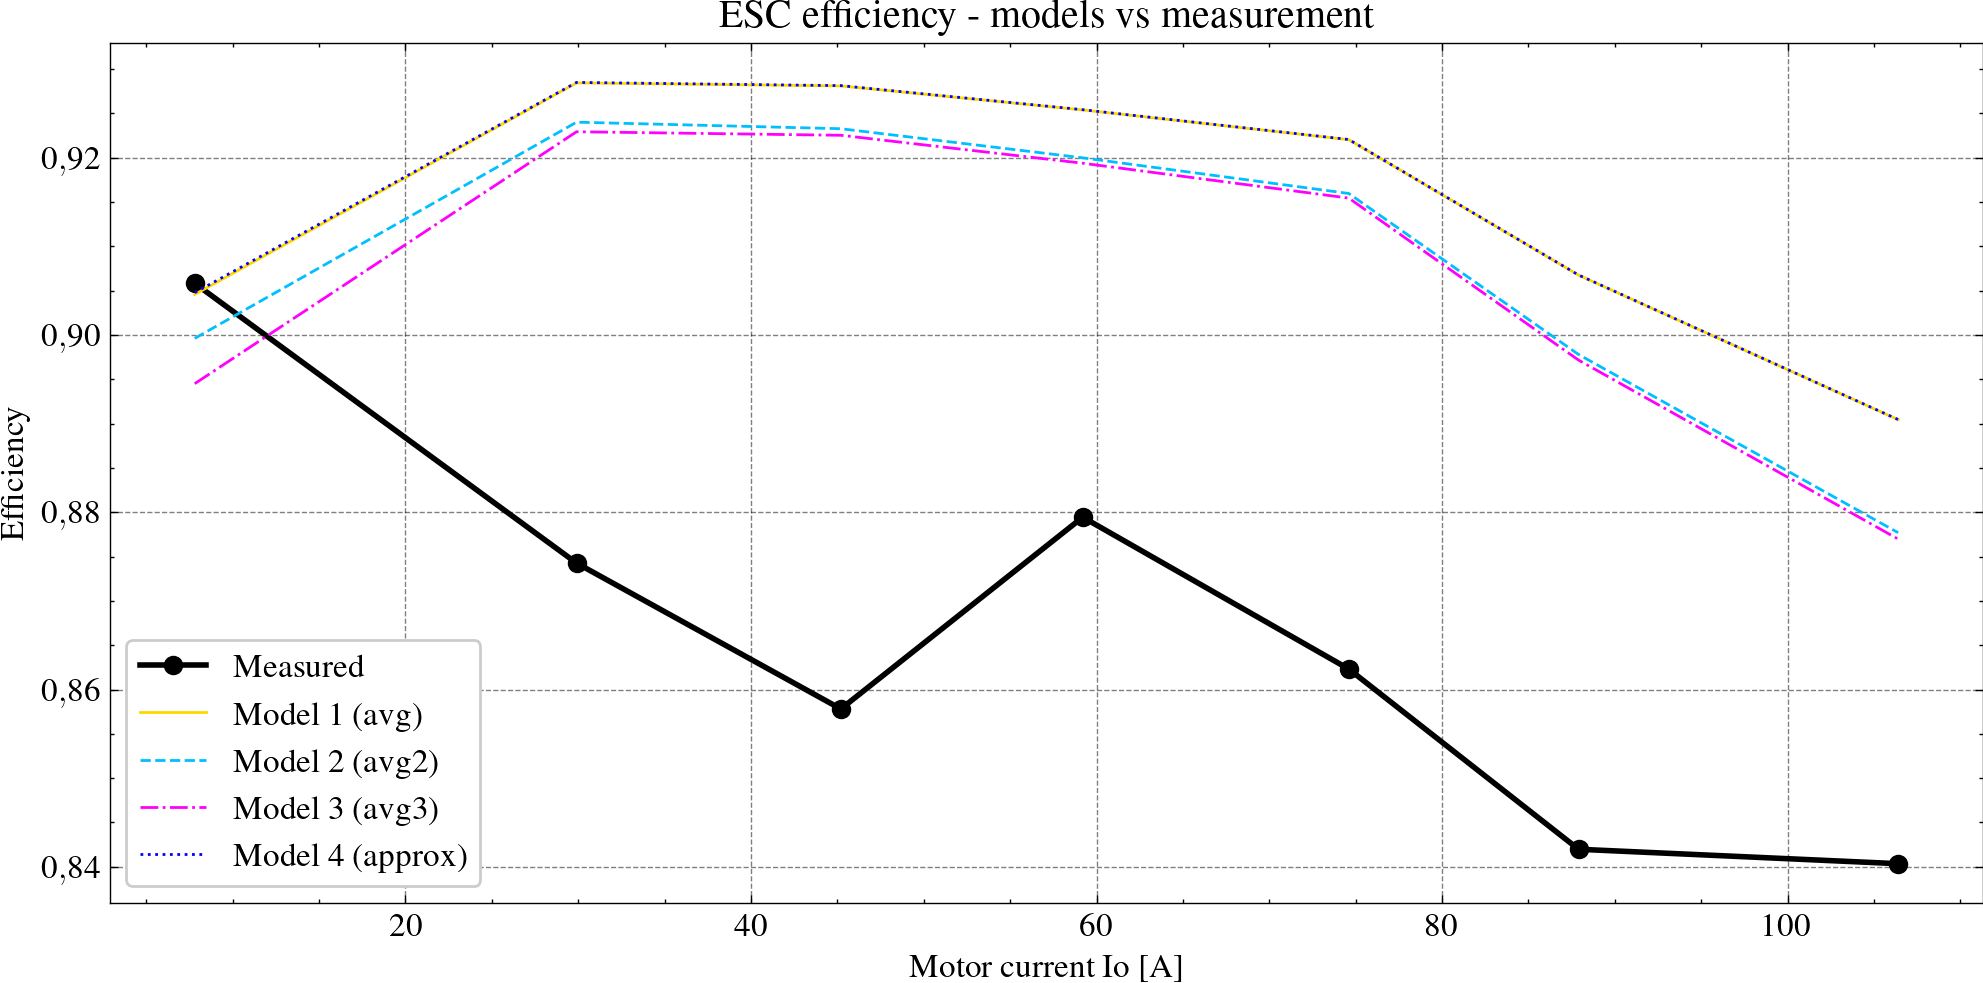

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1) Build measurement dataframe ===

df["Pi_meas"] = df["Ii"] * df["Vi"]
df["Po_meas"] = df["Io"] * df["Vo"]
df["eta_meas"] = df["Po_meas"] / df["Pi_meas"]
df.loc[0, ["eta_meas"]] = np.nan    # skip the zero row

# === 2) Duty cycle used in all your measurements ===
D_val = 0.5

# === 3) Helper to evaluate any ESC model ===
def eval_model(model_fn, df, esc_params):
    motor_v_list = []
    batt_i_list = []
    eta_list = []

    for idx, row in df.iterrows():
        if row["Vi"] <= 0 or row["Ii"] <= 0:
            motor_v_list.append(np.nan)
            batt_i_list.append(np.nan)
            eta_list.append(np.nan)
            continue

        motor_v, batt_i, P_loss = model_fn(row["Vi"], row["Io"], D_val, esc_params)

        Pin = row["Vi"] * batt_i
        Pout = motor_v * row["Io"]
        eta = Pout / Pin if Pin > 0 else np.nan

        motor_v_list.append(motor_v)
        batt_i_list.append(batt_i)
        eta_list.append(eta)

    return np.array(motor_v_list), np.array(batt_i_list), np.array(eta_list)

# === 4) Evaluate all models ===

df["eta_m1"] = eval_model(esc_model_avg,   df, esc_params)[2]
df["eta_m2"] = eval_model(esc_model_avg2,  df, esc_params)[2]
df["eta_m3"] = eval_model(esc_model_avg3,  df, esc_params)[2]
df["eta_m4"] = eval_model(esc_model_avg_4, df, esc_params)[2]

# === 5) Print comparison table ===

cols = ["Ii","Io","Vi","Vo","eta_meas","eta_m1","eta_m2","eta_m3","eta_m4"]
print(df[cols].round(4))

# === 6) Plot efficiency comparison ===

plt.figure(figsize=(10,5))
plt.plot(df["Io"], df["eta_meas"], "ko-", label="Measured", linewidth=2)
plt.plot(df["Io"], df["eta_m1"], "gold",  linestyle="solid",   label="Model 1 (avg)")
plt.plot(df["Io"], df["eta_m2"], "deepskyblue", linestyle="dashed", label="Model 2 (avg2)")
plt.plot(df["Io"], df["eta_m3"], "magenta", linestyle="dashdot", label="Model 3 (avg3)")
plt.plot(df["Io"], df["eta_m4"], "blue", linestyle="dotted", label="Model 4 (approx)")

plt.xlabel("Motor current Io [A]")
plt.ylabel("Efficiency")
plt.title("ESC efficiency - models vs measurement")
plt.grid(True)
plt.legend()
plt.show()
